## Time Series ForeCasting - Performance of Wind Turbine

Wind energy plays a crucial role in the global shift toward sustainable power generation. This notebook presents a comprehensive analysis of wind turbine performance using deep learning techniques, with a primary focus on Recurrent Neural Networks (RNNs) for time series forecasting.


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
!pwd

/Users/sumi/Desktop/WTPO/Notebooks


In [3]:
os.chdir('../')
!pwd

/Users/sumi/Desktop/WTPO


### 1. Read the data

In [4]:
dataset=pd.read_csv('DATA/T1.csv')
dataset.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


### 1.1 Data Description:
This data is taken from Wind Turbines Scada system that is working and generating power is turkey for the year 2018.

**Features:**
- Date/Time (for 10 minutes intervals)
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

### 2. EDA

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
# Convert 'Date/Time' to datetime format
dataset['Date/Time'] = pd.to_datetime(dataset['Date/Time'], format="%d %m %Y %H:%M", errors='coerce')


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


In [8]:
dataset.set_index('Date/Time', inplace=True)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50530 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            50530 non-null  float64
 1   Wind Speed (m/s)               50530 non-null  float64
 2   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 3   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


In [10]:
# Check for missing values
dataset.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [11]:
# Select the features
features= dataset.columns.tolist()
features

['LV ActivePower (kW)',
 'Wind Speed (m/s)',
 'Theoretical_Power_Curve (KWh)',
 'Wind Direction (°)']

In [12]:
dataset.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [13]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [14]:
# Convert the DataFrame to numpy array
data=dataset.values
data

array([[ 380.04779053,    5.31133604,  416.32890782,  259.99490356],
       [ 453.76919556,    5.67216682,  519.91751106,  268.64111328],
       [ 306.37658691,    5.2160368 ,  390.90001581,  272.56478882],
       ...,
       [2201.10693359,    8.43535805, 1788.28475526,   84.74250031],
       [2515.6940918 ,    9.42136574, 2418.38250336,   84.2979126 ],
       [2820.46606445,    9.97933197, 2779.18409628,   82.27462006]])

In [15]:
# Split the data into train test split
train_size=int(0.8*len(data))
test_size=len(data)-train_size

train_data, test_data= data[:train_size], data[train_size:]


> **NOTE:** We cannot use the scikit-learn's built-in `train_test_split` here as it splits data randomly but here we need to preserve the temporal component. 

In [16]:
# Standardize the data
scaler= MinMaxScaler(feature_range=(0,1))
train_data_scaled= scaler.fit_transform(train_data)
test_data_scaled= scaler.transform(test_data)


In [17]:
# Let's also create a validation split
val_size = int(0.1 * len(train_data_scaled))

train_data_final, val_data= train_data_scaled[:-val_size], train_data_scaled[-val_size:]


In [18]:
# Create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Assuming the first feature is the target
    return np.array(X), np.array(y)

time_step = 10  # Window Adjustable

X_train, y_train = create_sequences(train_data_final, time_step)
X_val, y_val = create_sequences(val_data, time_step)
X_test, y_test = create_sequences(test_data_scaled, time_step)


In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((36372, 10, 4), (36372,), (4032, 10, 4), (4032,), (10096, 10, 4), (10096,))

In [20]:
# Define the LSTM model
model=Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1) # Output layer (regression)
])

# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


/Users/sumi/miniforge3/envs/wtpEnv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
config=model.get_config()
config

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 10, 4),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'zero_output_for_mask': False,
    'units': 50,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUnifo

In [23]:
print("num_layers", len(config["layers"]))
print("model_type", type(model).__name__)
print("input_shape", str(model.input_shape))

num_layers 5
model_type Sequential
input_shape (None, 10, 4)


In [ ]:
optimizer_config = model.optimizer.get_config()
optimizer_config

{'name': 'adam',
 'learning_rate': 0.0010000000474974513,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [25]:
print("optimizer", optimizer_config["name"])
print("learning_rate", optimizer_config["learning_rate"])

optimizer adam
learning_rate 0.0010000000474974513


In [26]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0138 - mae: 0.0696 - val_loss: 0.0057 - val_mae: 0.0515
Epoch 2/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0052 - mae: 0.0416 - val_loss: 0.0058 - val_mae: 0.0518
Epoch 3/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0046 - mae: 0.0388 - val_loss: 0.0054 - val_mae: 0.0483
Epoch 4/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0048 - mae: 0.0391 - val_loss: 0.0055 - val_mae: 0.0505
Epoch 5/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0048 - mae: 0.0382 - val_loss: 0.0054 - val_mae: 0.0471
Epoch 6/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0044 - mae: 0.0375 - val_loss: 0.0052 - val_mae: 0.0479
Epoch 7/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0044 - mae: 0.0369 - val_loss: 0.0060 - val_mae: 0.0539
Epoch 8/10
1137/1137 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0045 - mae: 0.0376 - val_loss: 0.0055 - val_mae: 0.0508
Epoch 9/10
1137/1137 ━━━━━━━━━━━━━━━━━━━

In [28]:
print("val_mae", history.history['val_mae'][-1])
print("val_loss", history.history['val_loss'][-1])

val_mae 0.04927697032690048
val_loss 0.005370261613279581


In [29]:
optimizer_config = model.optimizer.get_config()
optimizer_config

{'name': 'adam',
 'learning_rate': 0.0010000000474974513,
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'loss_scale_factor': None,
 'gradient_accumulation_steps': None,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [24]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

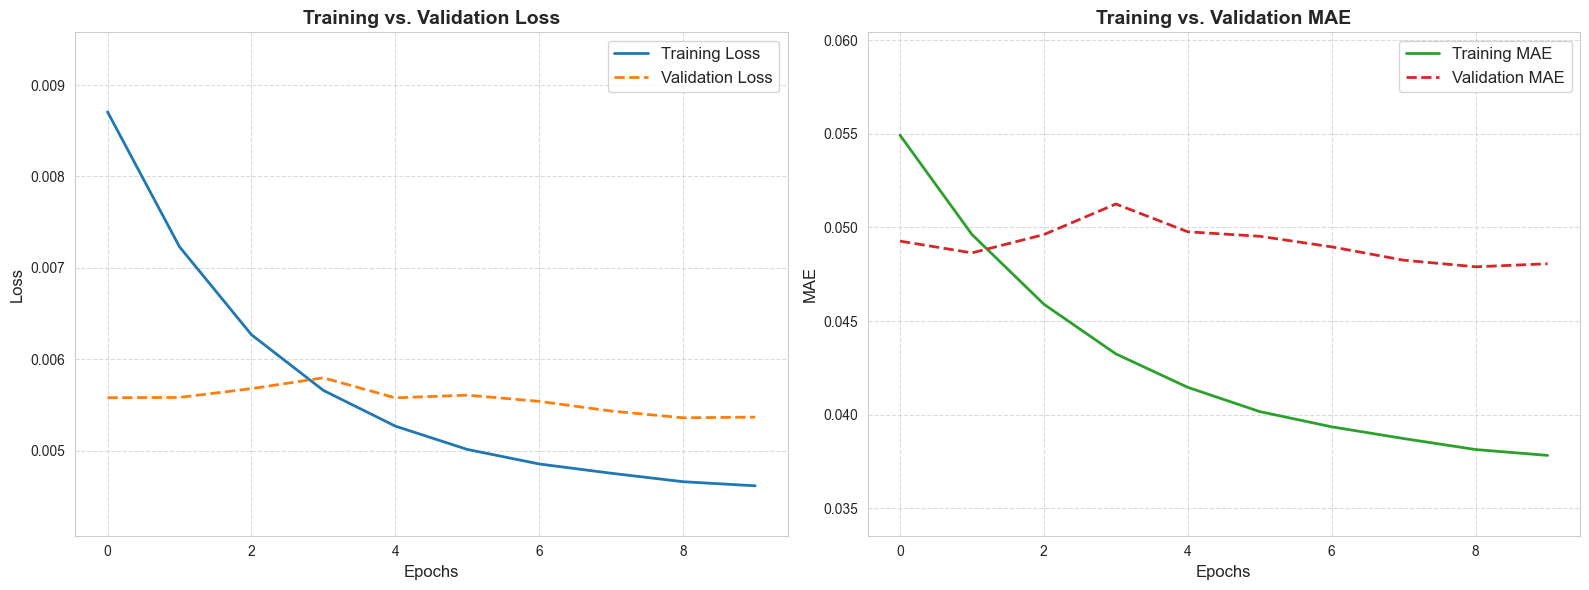

In [25]:
# Plot the training curves
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply Seaborn theme for a more professional look
sns.set_style("whitegrid")

# Function to apply moving average smoothing
def smooth_curve(values, smoothing=0.6):
    smoothed_values = []
    prev = values[0]  # Start with the first value
    for v in values:
        smoothed_val = prev * smoothing + v * (1 - smoothing)
        smoothed_values.append(smoothed_val)
        prev = smoothed_val
    return smoothed_values

# Extract loss and MAE data from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Smooth the curves for better visualization
train_loss_smooth = smooth_curve(train_loss, 0.6)
val_loss_smooth = smooth_curve(val_loss, 0.6)
train_mae_smooth = smooth_curve(train_mae, 0.6)
val_mae_smooth = smooth_curve(val_mae, 0.6)

# Create subplots for Loss and MAE
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Training & Validation Loss
axs[0].plot(train_loss_smooth, label='Training Loss', color='#1f77b4', linewidth=2)
axs[0].plot(val_loss_smooth, label='Validation Loss', color='#ff7f0e', linewidth=2, linestyle='dashed')
axs[0].set_title('Training vs. Validation Loss', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Epochs', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].legend(fontsize=12, loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_ylim(min(min(train_loss), min(val_loss)) * 0.9, max(max(train_loss), max(val_loss)) * 1.1)

# 📌 Plot 2: Training & Validation MAE
axs[1].plot(train_mae_smooth, label='Training MAE', color='#2ca02c', linewidth=2)
axs[1].plot(val_mae_smooth, label='Validation MAE', color='#d62728', linewidth=2, linestyle='dashed')
axs[1].set_title('Training vs. Validation MAE', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Epochs', fontsize=12)
axs[1].set_ylabel('MAE', fontsize=12)
axs[1].legend(fontsize=12, loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_ylim(min(min(train_mae), min(val_mae)) * 0.9, max(max(train_mae), max(val_mae)) * 1.1)

# 📌 Improve layout
plt.tight_layout()
plt.show()

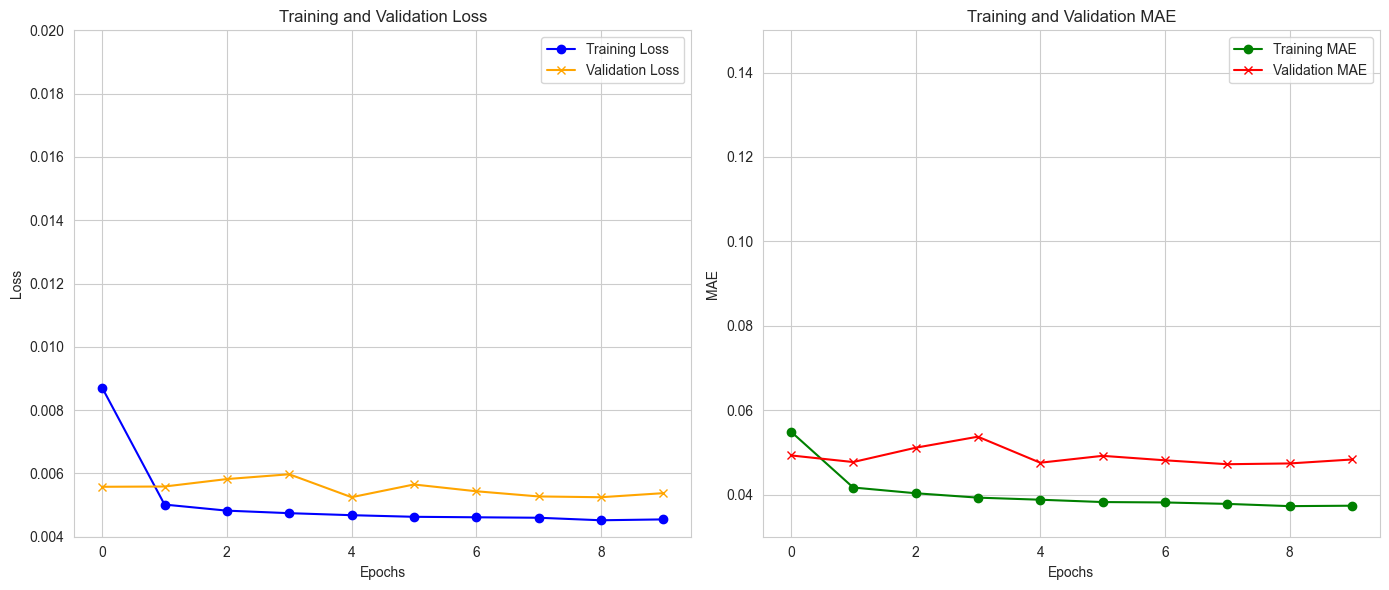

In [26]:
import matplotlib.pyplot as plt

# Create subplots for Loss and MAE
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss
axs[0].plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
axs[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_ylim(0.004, 0.020)  # Set y-axis range

# Plot training & validation MAE
axs[1].plot(history.history['mae'], label='Training MAE', color='green', marker='o')
axs[1].plot(history.history['val_mae'], label='Validation MAE', color='red', marker='x')
axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(0.03, 0.15)  # Set y-axis range

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [27]:
# Make predictions
y_pred= model.predict(X_test)
y_pred

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[0.00443948],
       [0.00642991],
       [0.0076572 ],
       ...,
       [0.4888992 ],
       [0.654287  ],
       [0.68782616]], dtype=float32)

In [28]:
y_pred.shape

(10096, 1)

In [29]:
# Flatten the predictions
y_pred= y_pred.flatten()
y_pred.shape

(10096,)

In [ ]:
num_features=len(features)
# Create an empty full array for inverse transformation
y_pred_full=np.zeros((y_pred.shape[0],num_features))
y_pred_full

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# Insert predictions into the first column
y_pred_full[:, 0]=y_pred
y_pred_full

array([[0.00443948, 0.        , 0.        , 0.        ],
       [0.00642991, 0.        , 0.        , 0.        ],
       [0.0076572 , 0.        , 0.        , 0.        ],
       ...,
       [0.4888992 , 0.        , 0.        , 0.        ],
       [0.65428698, 0.        , 0.        , 0.        ],
       [0.68782616, 0.        , 0.        , 0.        ]])

In [37]:
# Apply inverse transformation
y_pred_inverse = scaler.inverse_transform(y_pred_full)[:, 0]  # Extract only the first column
y_pred_inverse

array([  13.60487478,   20.81262869,   25.2568945 , ..., 1767.93249188,
       2366.83543259, 2488.28764141])

In [38]:
# If y_test was also scaled, inverse transform it for comparison
y_test_full = np.zeros((y_test.shape[0], num_features))  # Use the same number of features

In [41]:
y_test_full[:,0]=y_test
y_test_full

array([[6.82481521e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.82481521e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.82481521e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.08520853e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.95394481e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.79557634e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [42]:
y_test_inverse= scaler.inverse_transform(y_test_full)[:, 0]  # Extract only the first column
y_test_inverse

array([   0.        ,    0.        ,    0.        , ..., 2201.10693359,
       2515.6940918 , 2820.46606445])

In [43]:
# Calculate R2 Score
from sklearn.metrics import r2_score
r2= r2_score(y_test_inverse, y_pred_inverse)
r2

0.9707055628461002

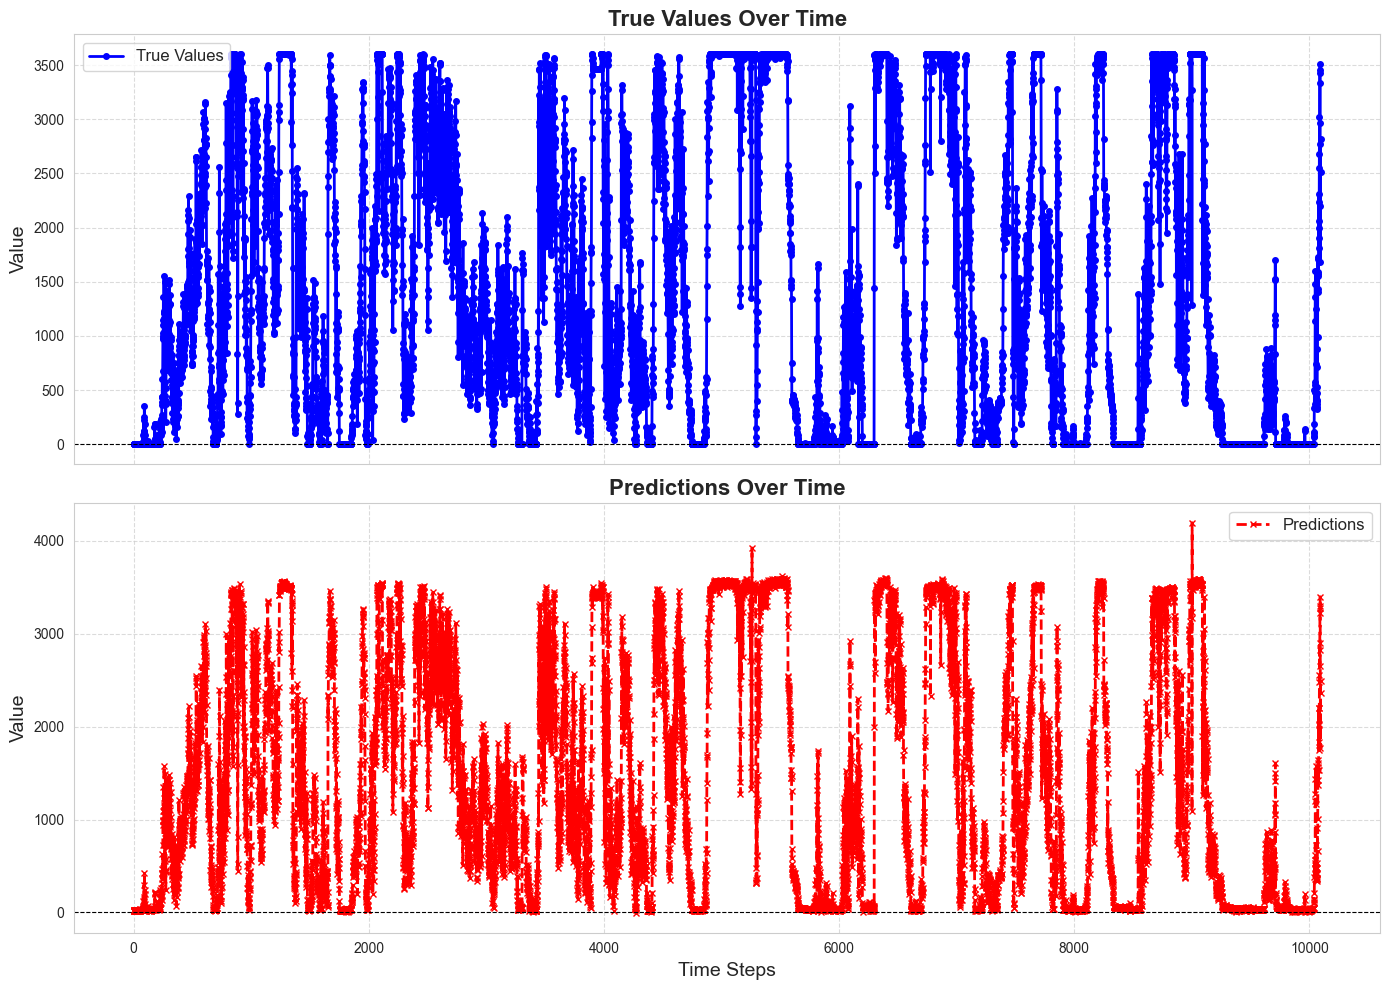

In [44]:
# Plot predictions and ground truth
# Create a time array
time_steps = np.arange(len(y_test_inverse))

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot True Values
axs[0].plot(time_steps, y_test_inverse, label='True Values', color='blue', linestyle='-', linewidth=2, marker='o', markersize=4)
axs[0].set_title('True Values Over Time', fontsize=16, fontweight='bold')
axs[0].set_ylabel('Value', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(visible=True, linestyle='--', alpha=0.7)

# Plot Predictions
axs[1].plot(time_steps, y_pred_inverse, label='Predictions', color='red', linestyle='--', linewidth=2, marker='x', markersize=4)
axs[1].set_title('Predictions Over Time', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Time Steps', fontsize=14)
axs[1].set_ylabel('Value', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(visible=True, linestyle='--', alpha=0.7)

# Add a reference horizontal line at y=0
for ax in axs:
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Improve spacing
plt.tight_layout()
plt.show()

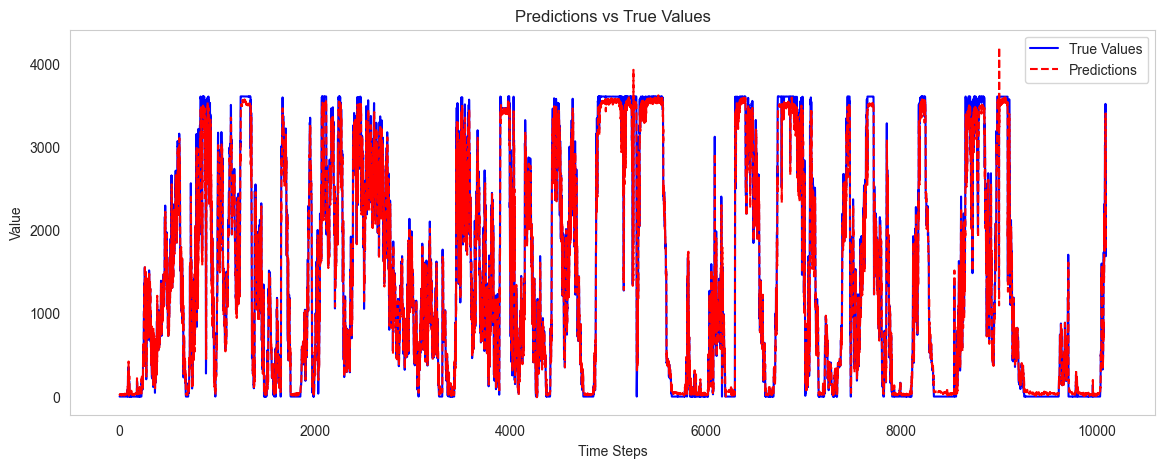

In [45]:
# Plot Predictions vs True Values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test_inverse, label='True Values', color='blue')
plt.plot(y_pred_inverse, label='Predictions', color='red', linestyle="dashed")
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

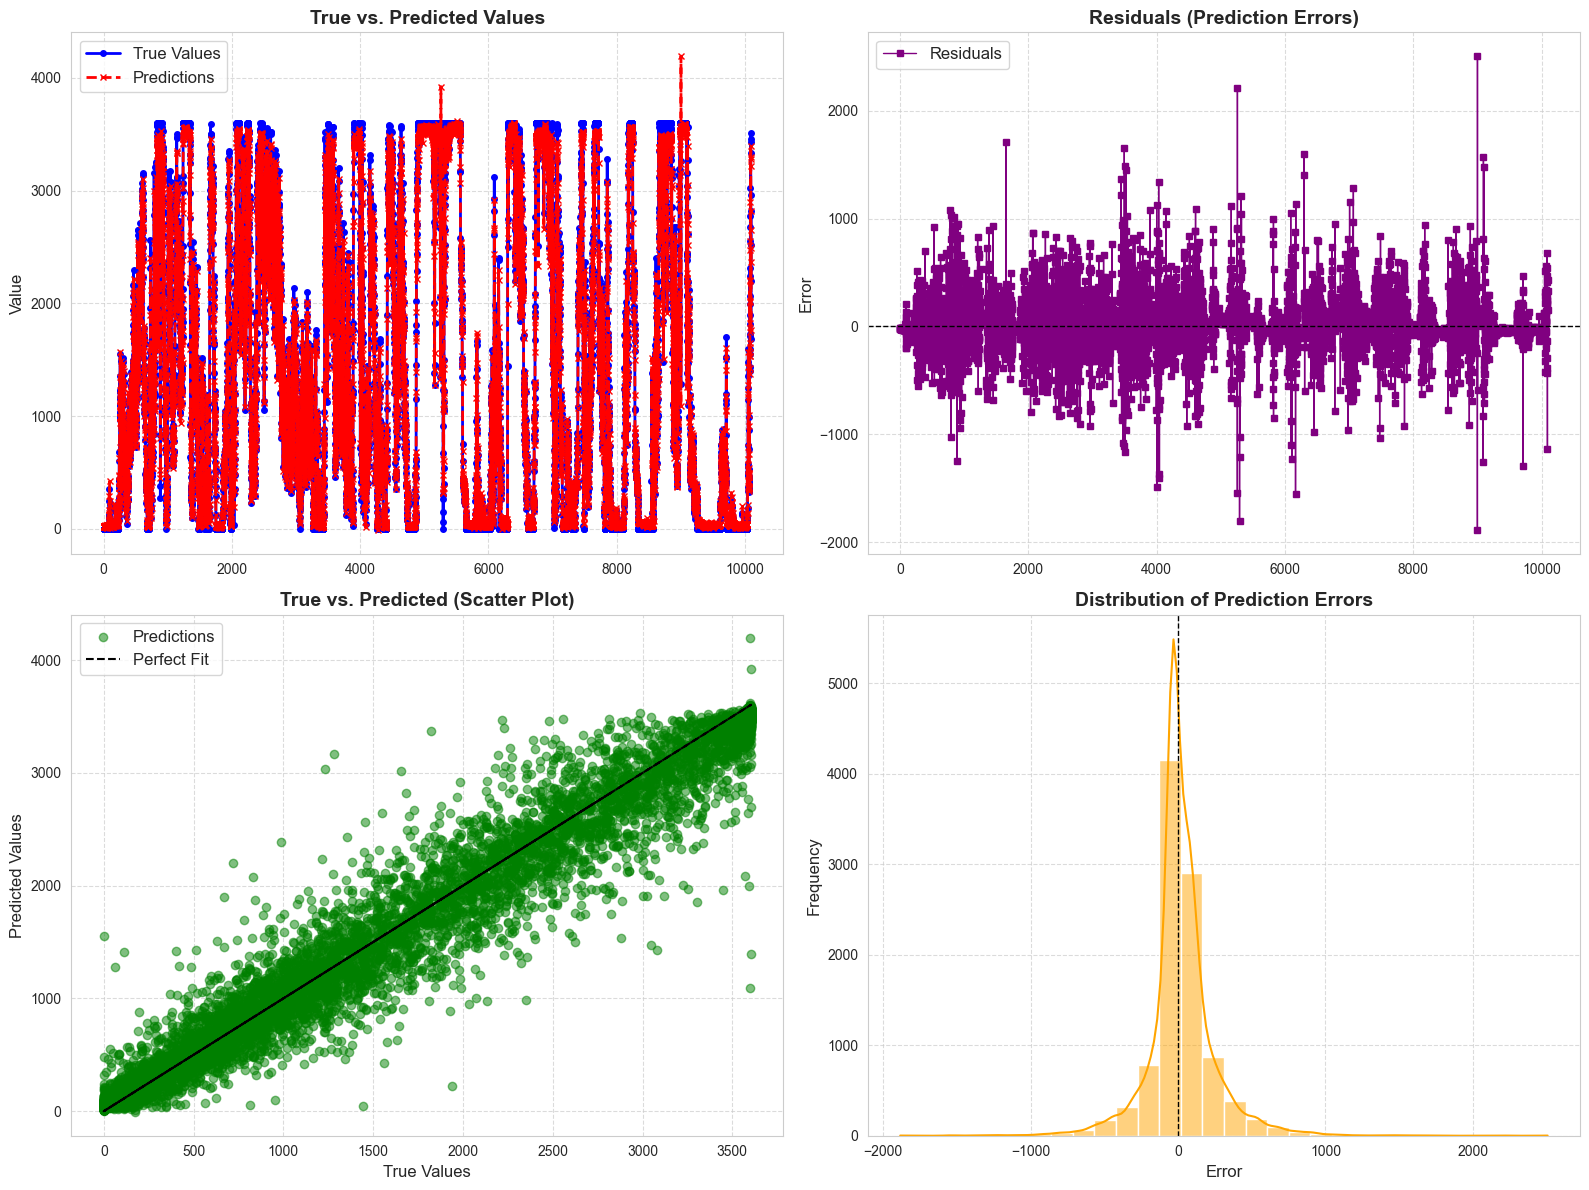

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

time_steps = np.arange(len(y_test_inverse))  # Create a time array

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: True vs. Predicted Values (Line Plot)
axs[0, 0].plot(time_steps, y_test_inverse, label='True Values', color='blue', linestyle='-', linewidth=2, marker='o', markersize=4)
axs[0, 0].plot(time_steps, y_pred_inverse, label='Predictions', color='red', linestyle='--', linewidth=2, marker='x', markersize=4)
axs[0, 0].set_title('True vs. Predicted Values', fontsize=14, fontweight='bold')
axs[0, 0].set_ylabel('Value', fontsize=12)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(visible=True, linestyle='--', alpha=0.7)

# Plot 2: Residual Plot (Errors)
residuals = y_test_inverse - y_pred_inverse
axs[0, 1].plot(time_steps, residuals, label='Residuals', color='purple', linestyle='-', linewidth=1, marker='s', markersize=4)
axs[0, 1].axhline(0, color='black', linewidth=1, linestyle='--')
axs[0, 1].set_title('Residuals (Prediction Errors)', fontsize=14, fontweight='bold')
axs[0, 1].set_ylabel('Error', fontsize=12)
axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(visible=True, linestyle='--', alpha=0.7)

# Plot 3: Scatter Plot of True vs. Predicted Values
axs[1, 0].scatter(y_test_inverse, y_pred_inverse, color='green', alpha=0.5, label='Predictions')
axs[1, 0].plot(y_test_inverse, y_test_inverse, color='black', linestyle='--', label='Perfect Fit')  # Reference line
axs[1, 0].set_title('True vs. Predicted (Scatter Plot)', fontsize=14, fontweight='bold')
axs[1, 0].set_xlabel('True Values', fontsize=12)
axs[1, 0].set_ylabel('Predicted Values', fontsize=12)
axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(visible=True, linestyle='--', alpha=0.7)

# Plot 4: Histogram of Residuals
sns.histplot(residuals, bins=30, kde=True, color='orange', ax=axs[1, 1])
axs[1, 1].axvline(0, color='black', linewidth=1, linestyle='--')
axs[1, 1].set_title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axs[1, 1].set_xlabel('Error', fontsize=12)
axs[1, 1].set_ylabel('Frequency', fontsize=12)
axs[1, 1].grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()